# <center><font size=5> Machine Learing</font></center>
<center><font size=3><i> Machine Learning- Validation KNN</i></font></center>  
<center><font size=3><i> Jie Guo</i></font></center>
<center><font size=3><i>3/5/2021</i></font></center>

---

In this problem will use validation sets to pick parameters for k-nearest neighbor (KNN) model. The data sets for this problem are healthcareTrain.csv and healthcareTest.csv

In [1]:
rm(list = ls())
library(class)
library(stats)
library(caret)
library(plyr)
library(flexclust)
library(data.table)
library(Matrix)
library(MASS)
library(ggplot2)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'flexclust' was built under R version 3.6.3"Loading required package: grid
Loading required package: modeltools
Warning message:
"package 'modeltools' was built under R version 3.6.3"Loading required package: stats4

Attaching package: 'modeltools'

The following object is masked from 'package:plyr':

    empty



In [2]:
adTrain = read.csv("healthcareTrain.csv")
numCols <- sapply(adTrain, is.numeric)
adTrain = adTrain[,numCols]
adTest = read.csv("healthcareTest.csv")

In [3]:
train <- adTrain[c("total_los","num_op","num_er","num_ndc","pre_total_cost","pre_CCI","pdc_80_flag")]

test <- adTest[c("total_los","num_op","num_er","num_ndc","pre_total_cost","pre_CCI","pdc_80_flag")]

In [4]:
test <- as.data.frame(lapply(test, as.numeric))
train <- as.data.frame(lapply(train, as.numeric))

### Nomalization

In [5]:
preObj <- preProcess(train[, 1:6], method="range")
adTrain.norm <- predict(preObj, train[, 1:6])
adTest.norm = predict(preObj, test[, 1:6])
trainlabel=train["pdc_80_flag" ]

### Creat K fold for cross validation

In [6]:
k_fold <- function(k,datasize,seed){
  cvlist <- list()
  set.seed(seed)
  n <- rep(1:k,ceiling(datasize/k))[1:datasize]    
  temp <- sample(n,datasize)  
  x <- 1:k
  dataseq <- 1:datasize
  cvlist <- lapply(x,function(x) dataseq[temp==x]) 
  return(cvlist)
}

In [7]:
k <- 10
datasize <- nrow(adTrain.norm)
kfold_index <- k_fold(k = k,datasize = datasize,seed = 123)

### Combine KNN model and cross validation

In [8]:
score_df <-c()
accuracyTable <- data.frame()
for(i in seq(31,101,by=2)){
    accuracy<-c()
    for (j in 1:10){
        X_train=adTrain.norm[-kfold_index[[j]],]
        X_test=adTrain.norm[kfold_index[[j]],]
        y_train=trainlabel[-kfold_index[[j]],]
        y_test=trainlabel[kfold_index[[j]],]
        
        knn_Label <- knn(train=X_train,
                          test=X_test,
                          cl=y_train, k=i)
        k_accuracy <- sum(y_test == knn_Label)/length(y_test)
        accuracy <-append(accuracy,k_accuracy)
        mean_accuracy=mean(accuracy)
        
    }
    
    score_df <-append(score_df,mean_accuracy)
    
}
        
       
k= seq(31,101,by=2)    
accuracyTable <- data.frame(k,score_df)
cat("K is",accuracyTable[which(accuracyTable[,2]==max(accuracyTable[,2])),1],"and the accuracy is",max(accuracyTable[,2]))

K is 33 and the accuracy is 0.6059611

### Plot the Accuracy

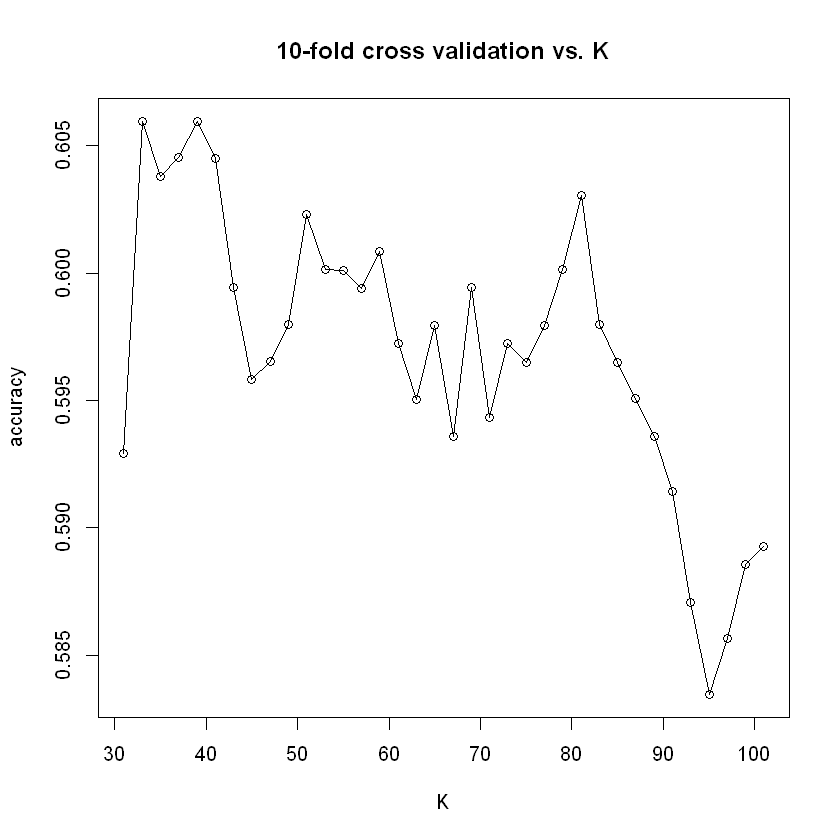

In [9]:
plot(x = accuracyTable$k,
     y = accuracyTable$score_df,
     type="o",
     main="10-fold cross validation vs. K",
     xlab="K",
     ylab="accuracy",
     )

### Compare test error and validation error

In [10]:
test_label=test["pdc_80_flag" ]
k_test_error=accuracyTable[which(accuracyTable[,2]==max(accuracyTable[,2])),1]
knn_Label2 <- knn(train=adTrain.norm,
                  test=adTest.norm,
                  cl=trainlabel$pdc_80_flag, k=k_test_error)
k_accuracy2 <- sum(test_label$pdc_80_flag == knn_Label2)/length(test_label$pdc_80_flag)
test_error=1-k_accuracy2
test_error

[1] 0.4156977

In [11]:
k_test_error

[1] 33

In [12]:
Validation_error=1-max(accuracyTable[,2])
Validation_error

[1] 0.3940389

so the validation error is smaller than test error